In [1]:
import pandas as pd
from string import punctuation

import nltk
import pymorphy2
import re

from tqdm import tqdm
import os

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt

import torch
from torch.utils.data.sampler import RandomSampler, SequentialSampler
from torch.utils.data import Dataset

from torchnlp.word_to_vector import FastText

import numpy as np
import random

torch.manual_seed(12)
torch.cuda.manual_seed(12)
np.random.seed(12)
random.seed(12)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Загружаем данные

In [2]:
path = '/home/ksenia/progas/python/int_trans/rureviews/women-clothing-accessories.3-class.balanced.csv'

In [3]:
df = pd.read_csv(path, sep='\t', header=0)

# Tiny EDA

In [4]:
df

,review,sentiment
0,качество плохое пошив ужасный (горловина напер...,negative
1,"Товар отдали другому человеку, я не получила п...",negative
2,"Ужасная синтетика! Тонкая, ничего общего с пре...",negative
3,"товар не пришел, продавец продлил защиту без м...",negative
4,"Кофточка голая синтетика, носить не возможно.",negative
...,...,...
89995,сделано достаточно хорошо. на ткани сделан рис...,positive
89996,Накидка шикарная. Спасибо большое провдо линяе...,positive
89997,спасибо большое ) продовца рекомендую.. заказа...,positive
89998,Очень довольна заказом! Меньше месяца в РБ. К...,positive


Посмотрим, есть ли дизбаланс

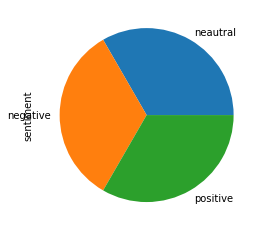

In [5]:
df['sentiment'].value_counts().plot(kind='pie')

Дизбаланса нет, супер!

# Препроцессинг

Загружаем стоп-слова и лемматизаторы для английского и для русского (потому что в датасете перемешанные языки)

In [6]:
nltk.download('stopwords')
russian_stopwords = nltk.corpus.stopwords.words("russian")
english_stopwords = nltk.corpus.stopwords.words("english")

[nltk_data] Downloading package stopwords to /home/ksenia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
rus_lemmatizer = pymorphy2.MorphAnalyzer()

In [8]:
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
eng_lemmatizer = nltk.stem.WordNetLemmatizer()

[nltk_data] Downloading package wordnet to /home/ksenia/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/ksenia/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Загружаем токенайзер

In [9]:
tokenizer = nltk.RegexpTokenizer(r"\w+")

Создаем резулярные выражения для русского и английского языков

In [10]:
rus_pattern = re.compile(r'[А-я]+')
eng_pattern = re.compile(r'[A-z]+')

Вспомогательные функции для предобработки

In [11]:
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": nltk.corpus.wordnet.ADJ,
                "N": nltk.corpus.wordnet.NOUN,
                "V": nltk.corpus.wordnet.VERB,
                "R": nltk.corpus.wordnet.ADV}
    return tag_dict.get(tag, nltk.corpus.wordnet.NOUN)

Удаляем из списка стоп-слова, которые могут влиять на таргет

In [12]:
def remove(word_list, words_to_remove):
    for word in words_to_remove:
        try:
            word_list.remove(word)
        except:
            pass

remove(russian_stopwords, ('не', 'никогда', 'хорошо', 'конечно', 'лучше', 'нельзя', 'наконец', 'еще', 'без'))

Функция для препроцессинга

In [13]:
def preprocess_line(row):
    line = row['review'].lower()
    tokens = tokenizer.tokenize(line)
    
    tokens = [token for token in tokens if token not in russian_stopwords\
              and token != " " \
              and token.strip() not in punctuation]
    
    tokens = [token for token in tokens if token not in english_stopwords\
              and token != " " \
              and token.strip() not in punctuation]
    
    normal_forms = []
    for token in tokens:
        if rus_pattern.match(token):
            normal_form = rus_lemmatizer.parse(token)[0].normal_form
            if normal_form not in russian_stopwords:    
                normal_forms.append(normal_form)
        elif eng_pattern.match(token):
            normal_form = eng_lemmatizer.lemmatize(token, get_wordnet_pos(token))
            if normal_form not in english_stopwords:    
                normal_forms.append(normal_form)
                
    row['tokens'] = normal_forms
    row['strat_kfold'] = '{}_{}'.format(row['sentiment'], len(normal_forms))
    return row

Запускаем препроцессинг (для всего датасета он занимает примерно 3 минуты)

In [14]:
tqdm.pandas()

In [15]:
df = df.progress_apply(preprocess_line, axis=1)

100%|██████████| 90000/90000 [03:14<00:00, 463.31it/s]


In [16]:
df

,review,sentiment,tokens,strat_kfold
0,качество плохое пошив ужасный (горловина напер...,negative,"[качество, плохой, пошив, ужасный, горловина, ...",negative_21
1,"Товар отдали другому человеку, я не получила п...",negative,"[товар, отдать, человек, не, получить, посылка...",negative_9
2,"Ужасная синтетика! Тонкая, ничего общего с пре...",negative,"[ужасный, синтетик, тонкий, общий, представить...",negative_20
3,"товар не пришел, продавец продлил защиту без м...",negative,"[товар, не, прийти, продавец, продлить, защита...",negative_10
4,"Кофточка голая синтетика, носить не возможно.",negative,"[кофточка, голый, синтетик, носить, не, возможно]",negative_6
...,...,...,...,...
89995,сделано достаточно хорошо. на ткани сделан рис...,positive,"[сделать, достаточно, хорошо, ткань, сделать, ...",positive_13
89996,Накидка шикарная. Спасибо большое провдо линяе...,positive,"[накидка, шикарный, спасибо, большой, провдо, ...",positive_16
89997,спасибо большое ) продовца рекомендую.. заказа...,positive,"[спасибо, большой, продовца, рекомендовать, за...",positive_6
89998,Очень довольна заказом! Меньше месяца в РБ. К...,positive,"[очень, довольный, заказ, маленький, месяц, рб...",positive_15


Загружаем эмбеддинги

In [17]:
ru_embeddings = FastText(language='ru')
en_embeddings = FastText(language='en')

# Разбиение на трейн и тест

Разобъем датасет с помощью приема, который используется для кросс-валидации. Я решила так поступить для того, чтобы распределения трейна и теста были как можно более похожими

In [18]:
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [19]:
for fold_number, (train_index, val_index) in enumerate(stratified_kfold.split(X=df.index, y=df['strat_kfold'])):
    df.loc[df.iloc[val_index].index, 'fold'] = fold_number

/home/ksenia/frow_home_projects/env/lib/python3.6/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Удаляем строки, которые после препроцессинга растеряли все слова

In [20]:
df = df[df['tokens'].apply(len) != 0]

In [21]:
df

,review,sentiment,tokens,strat_kfold,fold
0,качество плохое пошив ужасный (горловина напер...,negative,"[качество, плохой, пошив, ужасный, горловина, ...",negative_21,0.0
1,"Товар отдали другому человеку, я не получила п...",negative,"[товар, отдать, человек, не, получить, посылка...",negative_9,2.0
2,"Ужасная синтетика! Тонкая, ничего общего с пре...",negative,"[ужасный, синтетик, тонкий, общий, представить...",negative_20,1.0
3,"товар не пришел, продавец продлил защиту без м...",negative,"[товар, не, прийти, продавец, продлить, защита...",negative_10,2.0
4,"Кофточка голая синтетика, носить не возможно.",negative,"[кофточка, голый, синтетик, носить, не, возможно]",negative_6,2.0
...,...,...,...,...,...
89995,сделано достаточно хорошо. на ткани сделан рис...,positive,"[сделать, достаточно, хорошо, ткань, сделать, ...",positive_13,0.0
89996,Накидка шикарная. Спасибо большое провдо линяе...,positive,"[накидка, шикарный, спасибо, большой, провдо, ...",positive_16,0.0
89997,спасибо большое ) продовца рекомендую.. заказа...,positive,"[спасибо, большой, продовца, рекомендовать, за...",positive_6,3.0
89998,Очень довольна заказом! Меньше месяца в РБ. К...,positive,"[очень, довольный, заказ, маленький, месяц, рб...",positive_15,2.0


# Датасет

Класс для конвертации токенов в тензоры

In [22]:
class DatasetRetriever(Dataset):
    def __init__(self, df_dataset, max_amount_of_words):
        super().__init__()
        self.df_dataset = df_dataset
        self.index_values = df_dataset.index.values
        self.max_amount_of_words = max_amount_of_words
        
    def __getitem__(self, index: int):
        row = self.df_dataset.loc[self.index_values[index]]
        
        tensor = torch.zeros([self.max_amount_of_words, 300], dtype=torch.float32)
        counter = 0
        
        for token in row['tokens']:
            if counter >= self.max_amount_of_words:
                break
            
            if rus_pattern.match(token):
                tensor[counter, :] = ru_embeddings[token]
            elif eng_pattern.match(token):
                tensor[counter, :] = en_embeddings[token]
            
            if torch.sum(tensor[counter, :]) != 0:
                counter += 1
                
        label = 0
        if row['sentiment'] == 'neautral':
            label = 1
        elif row['sentiment'] == 'positive':
            label = 2
            
        # если ни один токен не имеет эмбеддинга, то устанавливаем лейбл = -1, 
        # чтобы потом отфильтровать этот тензор как невалидный
        if torch.sum(tensor) == 0:
            label = -1
            
        return tensor, label
    
    def __len__(self):
        return self.index_values.shape[0]

Пусть фолд с номером 0 будет валидационной выборкой

In [23]:
fold_number = 0

In [24]:
train_dataset = DatasetRetriever(df[df['fold'] != fold_number], 120)
val_dataset = DatasetRetriever(df[df['fold'] == fold_number], 120)

Проверяем, что датасет построился корректно

In [25]:
data = train_dataset[0]
data[0].shape

torch.Size([120, 300])

инициализируем переменные для нейронки и загрузчика данных

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 128
num_workers = 0

Создаем загрузчики данных для трейна и валидации

In [27]:
def collate_fn(batch):
    matrix_list = []
    label_list = []
    
    for matrix, label in batch:
        if label != -1:
            matrix_list.append(matrix)
            label_list.append(label)
            
    return matrix_list, label_list


train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    sampler=RandomSampler(train_dataset),
    pin_memory=False,
    drop_last=True,
    num_workers=num_workers,
    collate_fn=collate_fn,
)

val_loader = torch.utils.data.DataLoader(
    val_dataset, 
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=False,
    sampler=SequentialSampler(val_dataset),
    pin_memory=False,
    collate_fn=collate_fn,
)

# Модель

Я нашла статью (https://ieeexplore.ieee.org/document/8807792) от авторов датасета, и решила сделать похожую архитектуру

In [28]:
class Model(torch.nn.Module):
    def __init__(self, dim_in, dim_out):
        super(Model, self).__init__()
                
        dim1, dim2  = 8, 16
        
        self.cnn_layer1 = torch.nn.Sequential(
            torch.nn.Conv1d(dim_in, dim1, kernel_size=1, stride=1, padding=0, bias=False),
            torch.nn.BatchNorm1d(num_features=dim1),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv1d(dim1, dim2, kernel_size=1, stride=1, padding=0, bias=False),
            torch.nn.BatchNorm1d(num_features=dim2),
            torch.nn.ReLU(inplace=True),
        )
        self.cnn_layer2 = torch.nn.Sequential(
            torch.nn.Conv1d(dim_in, dim1, kernel_size=3, stride=1, padding=1, bias=False),
            torch.nn.BatchNorm1d(num_features=dim1),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv1d(dim1, dim2, kernel_size=3, stride=1, padding=1, bias=False),
            torch.nn.BatchNorm1d(num_features=dim2),
            torch.nn.ReLU(inplace=True),
        )
        self.cnn_layer3 = torch.nn.Sequential(
            torch.nn.Conv1d(dim_in, dim1, kernel_size=5, stride=1, padding=2, bias=False),
            torch.nn.BatchNorm1d(num_features=dim1),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv1d(dim1, dim2, kernel_size=5, stride=1, padding=2, bias=False),
            torch.nn.BatchNorm1d(num_features=dim2),
            torch.nn.ReLU(inplace=True),
        )
        self.cnn_layer4 = torch.nn.Sequential(
            torch.nn.Conv1d(dim_in, dim1, kernel_size=7, stride=1, padding=3, bias=False),
            torch.nn.BatchNorm1d(num_features=dim1),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv1d(dim1, dim2, kernel_size=7, stride=1, padding=3, bias=False),
            torch.nn.BatchNorm1d(num_features=dim2),
            torch.nn.ReLU(inplace=True),
        )
        self.cnn_layer5 = torch.nn.Sequential(
            torch.nn.Conv1d(dim_in, dim1, kernel_size=9, stride=1, padding=4, bias=False),
            torch.nn.BatchNorm1d(num_features=dim1),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv1d(dim1, dim2, kernel_size=9, stride=1, padding=4, bias=False),
            torch.nn.BatchNorm1d(num_features=dim2),
            torch.nn.ReLU(inplace=True),
        )
        
        self.max_pool1 = torch.nn.MaxPool1d(kernel_size=2)
        self.max_pool2 = torch.nn.MaxPool1d(kernel_size=2)
        self.max_pool3 = torch.nn.MaxPool1d(kernel_size=2)
        self.max_pool4 = torch.nn.MaxPool1d(kernel_size=2)
        self.max_pool5 = torch.nn.MaxPool1d(kernel_size=2)
        
        self.linear1 = torch.nn.Linear(12000, dim_out)
        
    def forward(self, matrix):
        x1 = self.cnn_layer1(matrix)
        x2 = self.cnn_layer2(matrix)
        x3 = self.cnn_layer3(matrix)
        x4 = self.cnn_layer4(matrix)
        x5 = self.cnn_layer5(matrix)
        
        x1 = self.max_pool1(x1)
        x2 = self.max_pool2(x2)
        x3 = self.max_pool3(x3)
        x4 = self.max_pool4(x4)
        x5 = self.max_pool5(x5)
        
        x1 = torch.flatten(x1, 1)
        x2 = torch.flatten(x2, 1)
        x3 = torch.flatten(x3, 1)
        x4 = torch.flatten(x4, 1)
        x5 = torch.flatten(x5, 1)
        
        x6 = torch.cat((x1, x2, x3, x4, x5), dim=1)
        x7 = self.linear1(x6)
        
        return x7

# Обучение

Загружаем модель на девайс

In [29]:
# 120 - максимальное количество слов, которые подаются на вход нейронке; 3 - количество классов
model = Model(120, 3)

model = model.to(device)

In [30]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [31]:
def train_one_epoch(nn_model, dataset_loader, loss_criterion, grad_optimizer):
    running_loss = 0.0
    nn_model.train()
    
    for batch_idx, (matrices, labels) in enumerate(dataset_loader):
        optimizer.zero_grad()
        
        batch_tensor = torch.stack(matrices).to(device)
        labels_tensor = torch.tensor(labels).to(device)
        
        outputs = nn_model(batch_tensor)
        loss = loss_criterion(outputs, labels_tensor)
        loss.backward()
        
        grad_optimizer.step()
        
        running_loss += loss.item()
        
        if batch_idx % 100 == 0 and batch_idx != 0:
            print('batch #{}\t accumulated_loss = {}\t current_loss = {}'.format(
                batch_idx, running_loss/batch_idx, loss.item()))
            
    return running_loss / len(dataset_loader)

In [32]:
def validate(nn_model, dataset_loader, loss_criterion):
    running_loss = 0.0
    accuracy = 0
    pred_array = []
    label_array = []
    
    with torch.no_grad():
        model.eval()
        
        for i, (matrices, labels) in enumerate(dataset_loader):
            batch_tensor = torch.stack(matrices).to(device)
            labels_tensor = torch.tensor(labels).to(device)

            outputs = nn_model(batch_tensor)
            loss = loss_criterion(outputs, labels_tensor)
            running_loss += loss.item()

            pred_array += torch.argmax(outputs, dim=1).tolist()
            label_array += labels

            accurate_predicted = torch.sum(torch.argmax(outputs, dim=1) == labels_tensor).item()
            accuracy += accurate_predicted
            
    print('----------------------------------------------validation')
    print('accumulated_loss:  ', running_loss/len(val_loader))
    print('confusion_matrix:\n', confusion_matrix(label_array, pred_array))
    print('classification_report:\n', classification_report(label_array, pred_array))
    print('\n\n\n')
    
    classification_report_dict = classification_report(label_array, pred_array, output_dict=True)    
    macro_f1 = classification_report_dict['macro avg']['f1-score']
    
    return running_loss / len(dataset_loader), macro_f1

In [33]:
checkpoints_path = 'checkpoints'
os.makedirs(checkpoints_path, exist_ok=True)

train_losses = []
val_losses = []

for epoch in range(10):
    print('----------------------------------------------epoch #{}'.format(epoch))
    
    train_loss = train_one_epoch(model, train_loader, criterion, optimizer)
    val_loss, macro_f1_score = validate(model, val_loader, criterion)
    
    torch.save(model.state_dict(), os.path.join(
        checkpoints_path, 'checkpoint_epoch_{}_f1_{}.pth'.format(epoch, int(macro_f1_score*100))))
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)

----------------------------------------------epoch #0
batch #100	 accumulated_loss = 1.024309542775154	 current_loss = 0.9400205016136169
batch #200	 accumulated_loss = 0.9667309445142745	 current_loss = 0.8359429836273193
batch #300	 accumulated_loss = 0.9258441617091496	 current_loss = 0.8597476482391357
batch #400	 accumulated_loss = 0.8934870705008506	 current_loss = 0.7693899273872375
batch #500	 accumulated_loss = 0.8700821202993393	 current_loss = 0.7895405888557434
----------------------------------------------validation
accumulated_loss:   0.7470575613035283
confusion_matrix:
 [[4061 1658  312]
 [1599 3514  878]
 [ 416 1090 4514]]
classification_report:
               precision    recall  f1-score   support

           0       0.67      0.67      0.67      6031
           1       0.56      0.59      0.57      5991
           2       0.79      0.75      0.77      6020

   micro avg       0.67      0.67      0.67     18042
   macro avg       0.67      0.67      0.67     18042
w

batch #100	 accumulated_loss = 0.5894210895895958	 current_loss = 0.5734207630157471
batch #200	 accumulated_loss = 0.5863297973573208	 current_loss = 0.6248311400413513
batch #300	 accumulated_loss = 0.5827113109827041	 current_loss = 0.546962320804596
batch #400	 accumulated_loss = 0.5849819654971361	 current_loss = 0.6233723759651184
batch #500	 accumulated_loss = 0.5837674698233605	 current_loss = 0.5885387063026428
----------------------------------------------validation
accumulated_loss:   0.6801986870631366
confusion_matrix:
 [[4373 1363  295]
 [1709 3258 1024]
 [ 270  719 5031]]
classification_report:
               precision    recall  f1-score   support

           0       0.69      0.73      0.71      6031
           1       0.61      0.54      0.58      5991
           2       0.79      0.84      0.81      6020

   micro avg       0.70      0.70      0.70     18042
   macro avg       0.70      0.70      0.70     18042
weighted avg       0.70      0.70      0.70     18042




Построим графики лоссов

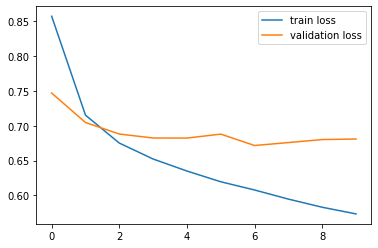

In [34]:
plt.plot(list(range(len(train_losses))), train_losses)
plt.plot(list(range(len(val_losses))), val_losses)
plt.legend(["train loss", "validation loss"])
plt.show()

# Выбор модели

Выбираем по f1-мере. берем веса, полученные на 6 эпохе 

In [45]:
model = Model(120, 3)
model = model.to(device)

In [37]:
model.load_state_dict(torch.load('checkpoints/checkpoint_epoch_6_f1_70.pth'))

In [42]:
running_loss = 0.0
accuracy = 0
pred_array = []
label_array = []

with torch.no_grad():
    model.eval()

    for i, (matrices, labels) in enumerate(val_loader):
        batch_tensor = torch.stack(matrices).to(device)
        labels_tensor = torch.tensor(labels).to(device)

        outputs = model(batch_tensor)
        loss = criterion(outputs, labels_tensor)
        running_loss += loss.item()

        pred_array += torch.argmax(outputs, dim=1).tolist()
        label_array += labels

        accurate_predicted = torch.sum(torch.argmax(outputs, dim=1) == labels_tensor).item()
        accuracy += accurate_predicted

print('----------------------------------------------validation')
print('accumulated loss:  ', running_loss/len(val_loader))
print('accuracy:  ', accuracy / len(label_array))
print('confusion_matrix:\n', confusion_matrix(label_array, pred_array))
print('classification_report:\n', classification_report(label_array, pred_array))
print('\n\n\n')

----------------------------------------------validation
accumulated loss:   0.6716561011025604
accuracy:   0.7063518456933822
confusion_matrix:
 [[4091 1757  183]
 [1380 3881  730]
 [ 250  998 4772]]
classification_report:
               precision    recall  f1-score   support

           0       0.72      0.68      0.70      6031
           1       0.58      0.65      0.61      5991
           2       0.84      0.79      0.82      6020

   micro avg       0.71      0.71      0.71     18042
   macro avg       0.71      0.71      0.71     18042
weighted avg       0.71      0.71      0.71     18042







In [43]:
classification_report_dict = classification_report(label_array, pred_array, output_dict=True)

In [44]:
print('macro_f1_measure: ', classification_report_dict['macro avg']['f1-score'])

macro_f1_measure:  0.7087714879725104
